# GPR

In GPR the Kernel defines a covariance matrix between a set of points in a space.

The most common kernel is the radial basis function RBF kernel, also known as exponential kernel or gaussian kernel.

$$K_{ij} = \sigma^2 \exp\left( - \frac{(x_i - x_j)²}{2 l²}  \right)$$

# Interpreting Lengthscale $l$, smoothness
$l$ defines the covariance between a point in space $x_i$ and another $x_j$, if $l$ is high then the points $x_i$ and $x_j$ will have a high covaraince even if they are far away, this means they are correlated and the predicted $y$ has to be similar for them both. This means the prediction will be smooth. The inverse argumnent is true for $l$ is small.

# Interpreting Sigma $\sigma$, amplitude
It is sometimes called the amplitude or just variance. It defines the variance of points with themselves. If $x_i = x_j$ then $K_ij = sigma²$. This defines the probability the fit can leave the prior mean. GPR is inheriently derived form bayesian stastics and thus has a prior. The prior mean is our guess of the function values at each point x. Usually it is set to 0 and said to be uninformative. $\sigma$ defines how likely it is for the fit to stray from the prior, so if we are confident about our prior we can set this to 0, if we are not sure we can set $\sigma$ to be large. A good rule of thumb is to set it to the order of magnitude of the $y$ values in the data.



In [76]:
import numpy as np
mse = np.array([0.1,0.1,0.1,0.1,0.5,0.6,0.7])
min = np.min(mse)
arg_mins = np.arange(len(mse))[mse==min]
max_arg_min_mse = np.max(arg_mins)
print(max_arg_min_mse)

3


In [151]:
from scipy.optimize import minimize, brute
import matplotlib.pyplot as plt

import pickle
import os
class Model():
    def __init__(self, name):
        self.parent = 'parent'
        if not os.path.exists('saved_models'):
            os.mkdir('saved_models')
        self.path = os.path.join('saved_models',name)
    
    def save(self, path=None):
        if path==None:
            path = self.path
        pickle.dump(self, open(path, 'wb'))

    
    def load(self,path=None):
        if path==None:
            path= self.path
        return pickle.load(open(path, 'rb'))

from GPy.models import GPRegression
from GPy.kern import RBF
import numpy as np

class GPR(Model):
    def __init__(self, name, data_noise_var=1.0):
        super().__init__(name)
        self.regressor = None
        self.model_type_id = 'gpr'
        self.fitted_lengthscale = None
        self.fitted_kernel = None
        self.data_noise_var = data_noise_var

    def mean_squared_error_given_l_is_deltax(self, x, y, oneD=True):
        variance = 2#np.max(y)
        y = np.array(y)[:, None] # GPy needs a 2D array
        print('OPTIMISING THE HYPERPERS BY MINIMISING THE MEAN SQUARED ERROR ie OVEFITTING')
        if oneD == True:
            dim = 1
            x = np.array(x)[:,None]
        else:
            dim == len(x[0])
            x = np.array(x)
        lengthscale = 20*np.mean(x[1:] - np.roll(x, 1)[1:])
        kernel = RBF(input_dim=dim, variance=variance, lengthscale=lengthscale ,ARD=True)
        regressor = GPRegression(x, y, kernel, noise_var=self.data_noise_var)
        y_pred, error = regressor.predict(x)
        plt.figure()
        plt.plot(x,y_pred, label='predictions')
        plt.plot(x,y, '.', label = 'data')

        mse = np.mean((y-y_pred)**2)
        print('MEAN SQUARE ERROR:')
        return mse


    def tune_hypers_mean_squared_error(self, x, y, variance=2.0, lengthscale=3, oneD=False, method='plot', bounds=(0,2)):
        y = np.array(y)[:, None] # GPy needs a 2D array
        print('OPTIMISING THE HYPERPERS BY MINIMISING THE MEAN SQUARED ERROR ie OVEFITTING')
        if oneD == True:
            dim = 1
            x = np.array(x)[:,None]
        else:
            dim == len(x[0])
            x = np.array(x)
        
        def mean_squared_error(l):
            kernel = RBF(input_dim=dim, variance=variance, lengthscale=l ,ARD=True)
            regressor = GPRegression(x, y, kernel, noise_var=self.data_noise_var)
            y_pred = regressor.predict(x)
            mse = np.mean((y-y_pred)**2)
            return mse
        
        print('OPTIMISING THE HYPERPERS:')
        if method =='plot':
            mse = []
            l_range = np.linspace(bounds[0],bounds[1], 50)
            for l in l_range:
                mse.append(mean_squared_error(l))
            plt.figure()
            print('mse',mse)
            plt.plot(l_range,mse)
            mse = np.nan_to_num(mse, nan=np.inf)
            min = np.min(mse)
            arg_mins = np.arange(len(mse))[mse==min]
            max_arg_min_mse = np.max(arg_mins)
            print('PLOT, L:', l_range[max_arg_min_mse], 'mamse', max_arg_min_mse)
            self.fitted_lengthscale = l_range[np.argmin(mse)]
        elif method =='brute':
            result = brute(mean_squared_error, ranges=[bounds], workers=1)
            print(result)
            print('BEST FIT LENGTHSCALE IS:',result)
            self.fitted_lengthscale = result
        else:
            result = minimize(mean_squared_error, method='Nelder-Mead', x0=[lengthscale], tol=1e-6, bounds=[bounds])
            print(result)
            print('BEST FIT LENGTHSCALE IS:',result.x)
            self.fitted_lengthscale = result.x
            
        kernel = RBF(input_dim=dim, variance=variance, lengthscale=self.fitted_lengthscale, ARD=True)
        self.fitted_kernel = kernel
        self.regressor = GPRegression(x, y, kernel, noise_var=self.data_noise_var)

    def tune_hypers_marginal_likelihood(self, x, y, variance=2.0, lengthscale=3, oneD=False): 
        y = np.array(y)[:, None] # GPy needs a 2D array
        print('OPTIMISING THE HYPERPERS BY MAXIMISING THE MARGINAL LIKELIHOOD ie NO OVERFITTING')
        if oneD == True:
            dim = 1
            x = np.array(x)[:,None]
        else:
            dim == len(x[0])
            x = np.array(x)
        kernel = RBF(input_dim=dim, variance=variance, lengthscale=lengthscale,ARD=True)
        self.regressor = GPRegression(x, y, kernel, noise_var=self.data_noise_var)
        print('CURRENT HYPERS:\n', self.regressor)
        print('OPTIMISING THE HYPERPERS:')
        self.regressor.optimize_restarts(num_restarts = 3)
        self.fitted_lengthscale = self.regressor.kern.lengthscale
        self.fitted_kernel = self.regressor.kern
        print('RESULTING HYPERS:\n',self.regressor)
    
    def predict(self, x, disclude_errors=False, oneD = False):
        if oneD:
            input = np.array(x)[:,None]
        else:
            input = np.array(x)
        if len(input.shape) == 1: #prediction for one point
            input = np.array([x])
        y_predict, y_var = self.regressor.predict(input)
        # print(y_predict.shape)
        # print(y_predict) 
        if disclude_errors:
            return y_predict[:,0] 
        else:
            y_2sig = np.sqrt(y_var[:,0]) * 2 
            return [y_predict[:,0], y_2sig]
    


# Simulated Data

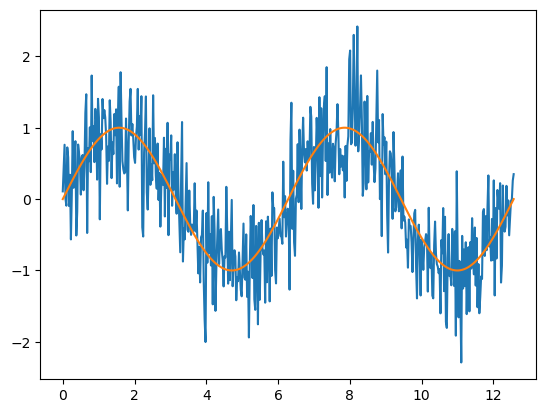

In [105]:
import matplotlib.pyplot as plt
import numpy as np


n_points = 500
x = np.linspace(0, 4*np.pi, n_points)
y = np.sin(x)
noise = np.random.normal(0,0.5, n_points)
y_noisy =y + noise


plt.plot(x,y_noisy)
plt.plot(x,y)

# GPR Smooth

OPTIMISING THE HYPERPERS BY MINIMISING THE MEAN SQUARED ERROR ie OVEFITTING
MEAN SQUARE ERROR:


3.344448231892001e-13

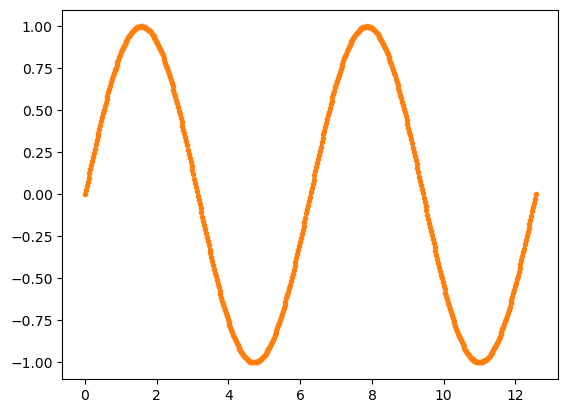

In [152]:
gpr_smooth = GPR('smooth', data_noise_var=0)

gpr_smooth.mean_squared_error_given_l_is_deltax(x,y)
# gpr_smooth.tune_hypers_mean_squared_error(x, y, oneD=True, method='plot')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FITTED LENGTHSCALE FOR SMOOTH FUNCTION:
   index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     0.08163265  |      +ve      |         0.08163265306122448
VARIANCE:
   index  |  GP_regression.rbf.variance  |  constraints  |  priors
  [0]    |                  2.00000000  |      +ve      |        


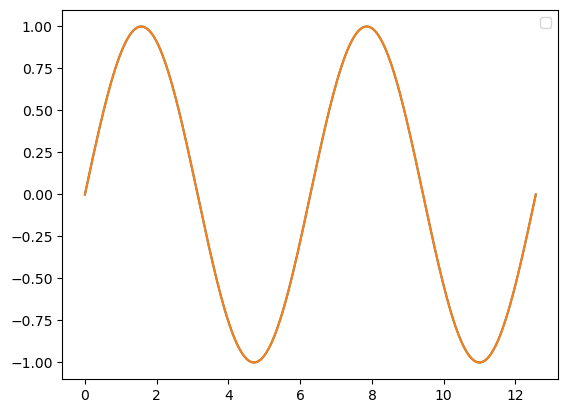

In [107]:
print('FITTED LENGTHSCALE FOR SMOOTH FUNCTION:\n', gpr_smooth.regressor.kern.lengthscale, gpr_smooth.fitted_lengthscale)
print('VARIANCE:\n', gpr_smooth.regressor.kern.variance)
pred, error = gpr_smooth.predict(x, oneD=True)

plt.figure()
plt.plot(x,y)
plt.plot(x, pred)
# plt.fill_between(x, pred-error, pred+error, label='2 sigma, confidance interval')
plt.legend()

# GPR Noisy

OPTIMISING THE HYPERPERS BY MINIMISING THE MEAN SQUARED ERROR ie OVEFITTING
MEAN SQUARE ERROR:


0.21606187949446415

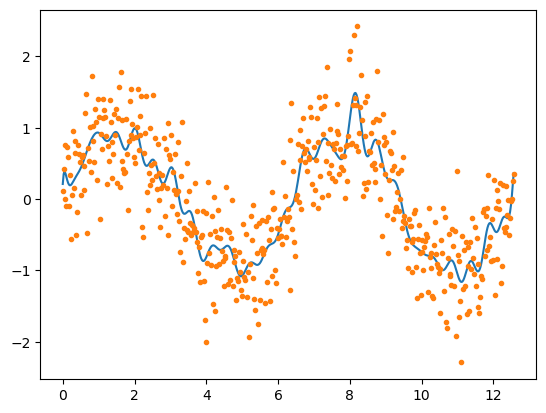

In [153]:
gpr_noisy = GPR('noisy', data_noise_var=0)

gpr_noisy.mean_squared_error_given_l_is_deltax(x, y_noisy)
# gpr_noisy.tune_hypers_mean_squared_error(x, y_noisy, oneD=True, method='plot')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FITTED LENGTHSCALE FOR NOISY FUNCTION:
   index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     0.04081633  |      +ve      |         0.04081632653061224
VARIANCE:
   index  |  GP_regression.rbf.variance  |  constraints  |  priors
  [0]    |                  2.00000000  |      +ve      |        


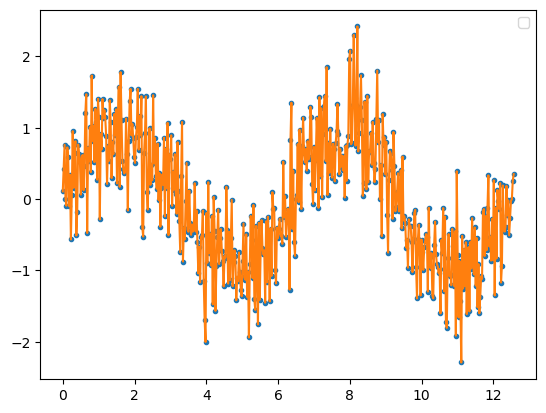

In [109]:
print('FITTED LENGTHSCALE FOR NOISY FUNCTION:\n', gpr_noisy.regressor.kern.lengthscale, gpr_noisy.fitted_lengthscale)
print('VARIANCE:\n', gpr_noisy.regressor.kern.variance)

pred, error = gpr_noisy.predict(x, oneD=True)

plt.figure()
plt.plot(x,y_noisy, '.')
plt.plot(x, pred)
# plt.fill_between(x, pred-error, pred+error, label='2 sigma, confidance interval')
plt.legend()

[0.02518311 0.05036621 0.07554932 0.10073243 0.12591554]
[0.         0.02518311 0.05036621 0.07554932 0.10073243]
0.025183107443605555


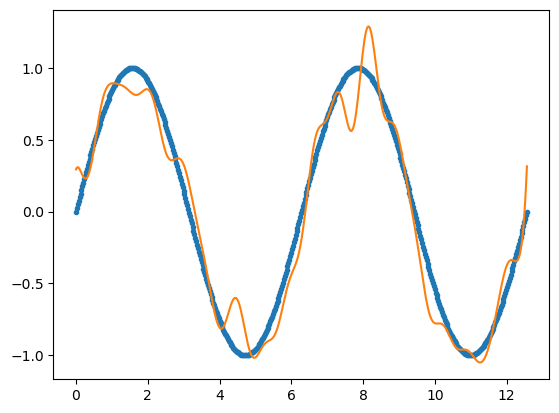

In [141]:
deltax = np.mean(x[1:] - np.roll(x, 1)[1:])
print(x[1:6])
print(np.roll(x,1)[1:6])
print(deltax)

kernel = RBF(input_dim=1, variance=2, lengthscale=0.75,ARD=True)

regressor = GPRegression(x[:,None], y_noisy[:,None], kernel, noise_var=0)
        
pred, error = regressor.predict(x[:,None])

plt.figure()
plt.plot(x,y, '.')
plt.plot(x,pred)

        

# Find the mse when the lengthscale = seperation between the points.

This gets over the issue that when you have lots of data a low lengthscale will always very closely match the data. 

The logic is that if the lengthscale is the seperation between the points and the function is smooth then the resulting prediction should be a good fit. If the function is not smooth then the function will be a bad fit.